# Classical Decompostion Introduction 

## Introduction

A time series data can be written as four components: trend component $y_t$, cylical component $C_t$, seasonal component $S_t$, and residual component $E_t$. 

    Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.

    Seasonal
A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.

    Cyclic
A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.

    Residual
Containing anything else in the time series



For time series decomposion, there are two types, the one is additive model, the other is multiplicative model, which can be written as

$ y_t = T_t + C_t + S_t + E_t $    
$ y_t = T_t * C_t * S_t * E_t $   

For simplfy the problem, we usually combine trend and cylical as trend-cycle component. Here we group $T_t$ and $C_t$ as trend-cycle component $G_t$. Hence the time series become

$ y_t = G_t + S_t + E_t  $  
$ y_t = G_t * S_t * E_t  $




Question：What does classical mean?

## ETS Decomposition of Additive Mode

One of widely use in time series decomposition is **ETS** Decomposition, ETS denote as error, trend and seasonal. The math behind this method is simple. Take additive model for example

- Step1: Estimate the trend-cycle factor by centered moving average, here we set $d$ as one period  
    if $d = 2q$ (even)  
$ G_t = (\frac{1}{2}y_{t-q}  + y_{t-q+1}   +  ...  +  y_{t+q-1}  +  \frac{1}{2}y_{t+q})  /  d $
    
    if $d = 2q+1$ (odd)  
$ G_t = (y_{t-q}  + y_{t-q+1}   +  ...  +  y_{t+q-1}  +  y_{t+q})  /  d  $

This implicate that the seasonal component and residual component can be removed over a period.

- Step2: Calculate the detrend series for seasonal and residual part only.  
$ y_t - G_t = S_t + E_t $  


- Step3: Estimate the seasonal component. For example, if we have a time series which contain monthly data, for seasonal component of Jan., simply average all Jan. of detrend value, and adjust to ensure the summation of one period(denote as $d$, here is 12 months, hence $d=12$) seasonal component is $0$. Then expand the 12 seasonal components to all time series, which means we assume seasonal component repeat from year to year. Expressed as math  
    $ a_t = \frac{1}{L / d}\sum_{k}^{k<=L}(y_k - G_k) $  
    $ k= (t + n*d)$, where $n = 0, 1, 2, ...$  
    $ L $ is the total count of time series  
    $ L/d$ sholud take round-down to integer

    $ S_t = a_t - <a_t>$,   $t = 1, 2, ..., d$ 
    
    $ <S_t> = \sum_{k=1}^{d}S_t = 0 $  



- Step4: The residual component is calculated by subtracting the estimated seasonal and trend-cycle components.  
$ E_t = y_t - G_t - S_t $  

From above math, we can see there are many assumptions for ETS decomposition, like
-  A series of interest comprises of three underlying components which combine to produce the data under investigation. These three components are the trend-cycle, the seasonal component and the residual component. These three components are independt function.
-  Assume the series can be expressed as additive or multiplicative decomposition respectively.
-  Residual component can be removed by averaging out, hence the seasonal component can be isolated. See step3 $a_t$ calculation.
-  Seasonal component is constant from year to year, but in real world it may change from time to time.
-  Another complexity that must be dealt with is what to do at the ends of the series. Because the average is centered, the first and last few averages cannot be computed (because of the lack of data).

## Reproduce Python Seasonal_Decompose Function of Additive Mode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the dataset
airline = pd.read_csv("../Dataset/airline_passengers.csv", index_col="Month")

###### test area #####
#airline.head()
#airline.index
###### end of test area #####

# Clean the dataset, remove null value
null_condition = airline['Thousands of Passengers'].isnull()
airline[null_condition].empty

if airline[null_condition].empty == False:
    airline.dropna(inplace=True)
else:
    airline = airline

# Change the dataset index to datatime type
airline.index = pd.to_datetime(airline.index)

###### test area #####
#airline.index
#airline.head()
###### end test area #####

In [3]:

#airline["trend_cycle_component"] = np.zeros(len(airline))
#airline["trend_cycle_component"][1] = None
#data_count = len(airline)
#a = np.asarray(airline)
#x = np.asarray(airline).reshape(1, data_count)
#x[0][0:5].shape
#data_count

In [4]:
# Define centered moving average coefficients 
def MA_centered_coefficient(freq):
    
    if freq % 2 == 0:  ## total count for the filt array is equal to (freq+1)
        filt = np.array([.5] + [1] * (freq - 1) + [.5]) / freq   # [1]*(freq -1) is broadcasting   
    else:  ## total count for the filt array is equal freq+1
        filt = np.repeat(1./freq, freq)   
    return filt

###### test area #####
#freq = 5
#a = MA_centered_coefficient(freq)
#a.shape
#np.dot(a,a) 
###### end test area #####

In [5]:
# Define the trend-cycle component function
def trend_cycle_component(x, freq):

    data_count = len(x)
    trend = np.zeros(data_count)  # initial the trend array elements as 0
    # input x is data frame type, but coeffieint is array type
    x = np.asarray(x).squeeze() # change input to array type and use .squeeze() to make same shape with coefficient variable
    coefficient = MA_centered_coefficient(freq)
    
    # set null value for head & tail column, this property is due to the centered moving average definition
    # in general, the first q
    # for freq = 4, 5, the first 2 and the end of 2 elements are null value
    # for freq = 6, 7, the first 3 and the end of 3 elements are null value 
    if freq % 2 == 0:
        q = int(freq/2)   # freq=2q
    else:
        q = int((freq - 1) / 2)   # freq=2q+1
        
    for index in range(data_count):
        if index < q:
            trend[index] = None
        elif index >= (data_count-q):
            trend[index] = None
        else:
            a = index-q
            b = index+q+1
            temp_array = x[a:b]
            trend[index] = np.dot(temp_array, coefficient)
    
    return trend

###### test area #####
#trend_cycle = trend_cycle_component(airline, 5)
#trend_cycle
#trend_cycle.shape
###### end test area #####

In [6]:
"""
## test trend_cycle_component function by convolution_filter
from statsmodels.tsa.filters.filtertools import convolution_filter

a = MA_centered_coefficient(5)
trend = convolution_filter(airline, a)
trend_array = np.asarray(trend).squeeze()
trend_array - trend_cycle
"""

'\n## test trend_cycle_component function by convolution_filter\nfrom statsmodels.tsa.filters.filtertools import convolution_filter\n\na = MA_centered_coefficient(5)\ntrend = convolution_filter(airline, a)\ntrend_array = np.asarray(trend).squeeze()\ntrend_array - trend_cycle\n'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000235D8722D30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000235D889EFD0>], dtype=object)

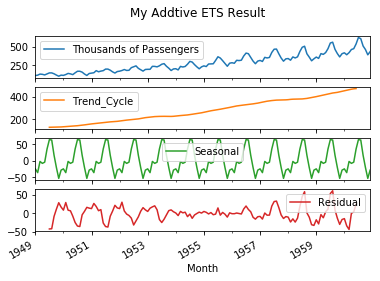

In [7]:
# Define the detrend series &  estimate the seasonal component
def ETS_decompose(x, freq, model='additive'):
    data_count = len(x)
    trend_cycle = trend_cycle_component(x, freq)  # calculate the trend-cycle term
    x_squ = np.asarray(x).squeeze()
    
    # caculate the detrend data
    if model == 'additive':
        detrend = x_squ - trend_cycle    
    elif model == 'multiplicative':
        detrend = x_squ / trend_cycle
    
    # pick-up the same seasonal index as an array
    seasonal_array = np.array([detrend[i::freq] for i in range(freq)])
    
    # calculate the average of elements in same seasonal index, note that we should exclude NAN value
    seasonal_index = np.zeros(freq) # 
    for index in range(freq):       
        #temp = np.isnan(seasonal_array[index])
        #seasonal_index[index] = seasonal_array[index][~temp].mean()
        seasonal_index[index] = np.nanmean(seasonal_array[index])
    
    # adjust to sum over seasonal component=0 or 1 for additive and multiplicative respectivily
    period_averages = seasonal_index.mean() 
    if model == 'additive':
        seasonal_index = seasonal_index - period_averages
    elif model =='multiplicative':
        seasonal_index = seasonal_index / period_averages
    
    # expand one period of seasonal data to full set
    seasonal = np.tile(seasonal_index, data_count // freq + 1)[:data_count]
    
    # calculate the residual component
    if model == 'additive':
        resid = detrend - seasonal
    elif model == 'multiplicative':
        resid = detrend / seasonal
    
    ETS_result = x.copy()
    ETS_result['Trend_Cycle'] = trend_cycle
    ETS_result['Seasonal'] = seasonal
    ETS_result['Residual'] = resid
    
    return ETS_result

ETS_result = ETS_decompose(airline, 12, model = 'additive')
ETS_result.plot(subplots=True, title='My Addtive ETS Result')


C:\Users\oldan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


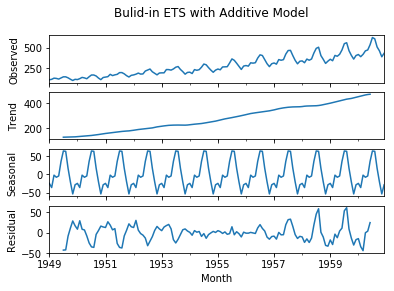

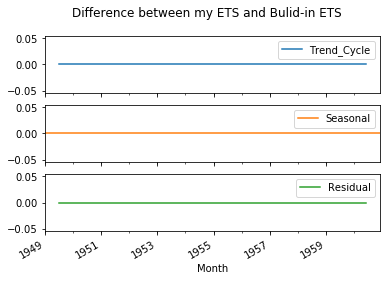

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# for add title on build-in ETS decomposition
def build_in_ETS_fig(x, title=''):
    fig, axes = plt.subplots(4, 1, sharex=True)
    x.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    x.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    x.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    x.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    fig.suptitle(title)
    
    return fig

build_in_result = seasonal_decompose(airline['Thousands of Passengers'], model='additivie', freq=12)
build_in_ETS_fig(build_in_result, title='Bulid-in ETS with Additive Model')


        
# plot figure to check if my result is actually same as Python seasonal_decompose
a = build_in_result.trend - ETS_result['Trend_Cycle']
b = build_in_result.seasonal - ETS_result['Seasonal']
c = build_in_result.resid - ETS_result['Residual']

difference =  pd.concat([a,b,c], axis=1,  join_axes=[a.index])
difference.columns=['Trend_Cycle', 'Seasonal', 'Residual']
difference_plot = difference.plot(subplots=True, title='Difference between my ETS and Bulid-in ETS')


## Using Additive Mode with Log Transformation to Extract Mulitplicative Behavior

For multiplicative model, the time series can be wrtten as  
$ y_t = G_t * S_t * E_t  $

Take log on both side, we will get  
$ Log(y_t) = Log(G_t) + Log(S_t) + Log(E_t) $  
So, we can fit a multiplicative relationship by fitting a more convenient additive relationship to the logarithms of the data and then to move back to the original series by taking exponential.  
When apply log transformation, one should make sure there is no $<=0$ in your data set, sicne there is no definition in Log function. But what can we do when we have negative data? There are two way to handle this situation,
- Apply standard multiplicative ETS.
- Add a constant vaule to original data set to make them all positive, then apply log transformation then move back by taking exponential and subtracting the constant.  

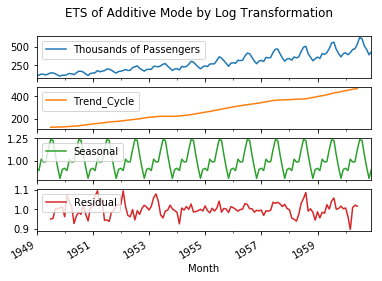

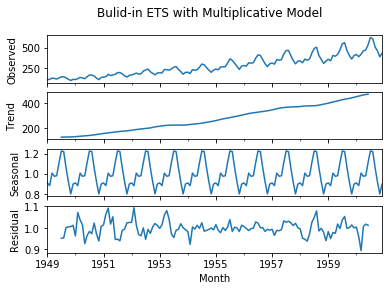

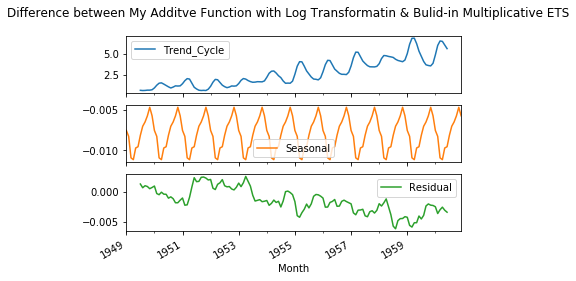

In [9]:
# test multiplicative model by additive function, first apply log function to raw data
raw_data_log = np.log(airline)
ETS_additive_Log = ETS_decompose(raw_data_log, 12)
ETS_additive_exp = np.exp(ETS_additive_Log)
ETS_additive_exp.plot(subplots=True, title='ETS of Additive Mode by Log Transformation')



# build-in ETS fo multiplicative mode
build_in_result_multi = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative', freq=12)
build_in_ETS_fig(build_in_result_multi, title='Bulid-in ETS with Multiplicative Model')

a1 = build_in_result_multi.trend - ETS_additive_exp['Trend_Cycle']
a2 = build_in_result_multi.seasonal - ETS_additive_exp['Seasonal']
a3 = build_in_result_multi.resid - ETS_additive_exp['Residual']

difference_1 =  pd.concat([a1,a2,a3], axis=1,  join_axes=[a1.index])
difference_1.columns=['Trend_Cycle', 'Seasonal', 'Residual']
difference_1_plot = difference_1.plot(subplots=True, title='Difference between My Additve Function with Log Transformatin & Bulid-in Multiplicative ETS')



## ETS Decomposition of Multiplicative Mode -- Standard Method

$ y_t = G_t * S_t * E_t  $

- Step1: Estimate the trend-cycle factor by centered moving average, here we set $d$ as one period  
    if $d = 2q$ (even)  
$ G_t = (\frac{1}{2}y_{t-q}  + y_{t-q+1}   +  ...  +  y_{t+q-1}  +  \frac{1}{2}y_{t+q})  /  d $
    
    if $d = 2q+1$ (odd)  
$ G_t = (y_{t-q}  + y_{t-q+1}   +  ...  +  y_{t+q-1}  +  y_{t+q})  /  d  $

This implicate that the seasonal component and residual component can be removed over a period.

- Step2: Calculate the detrend series for seasonal and residual part only.  
$ y_t / G_t = S_t * E_t $  


- Step3: Estimate the seasonal component. For example, if we have a time series which contain monthly data, for seasonal component of Jan., simply average all Jan. of detrend value, and adjust to ensure the summation of one period(denote as $d$, here is 12 months, hence $d=12$) seasonal component is $0$. Then expand the 12 seasonal components to all time series, which means we assume seasonal component repeat from year to year. Expressed as math  
    $ a_t = \frac{1}{L / d}\sum_{k}^{k<=L}\frac{y_k}{G_k} $  
    $ k= (t + n*d)$, where $n = 0, 1, 2, ...$  
    $ L $ is the total count of time series  
    $ L/d$ sholud take round-down to integer

    $ S_t = \frac{a_t}{<a_t>}$,   $t = 1, 2, ..., d$ 
    
    $ <S_t> = \sum_{k=1}^{d}S_t = 1 $  



- Step4: The residual component is calculated by subtracting the estimated seasonal and trend-cycle components.  
$ E_t = \frac{y_t}{(G_t*S_t)} $  

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000235DB25A898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000235DB35D518>], dtype=object)

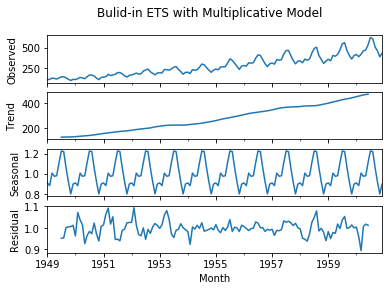

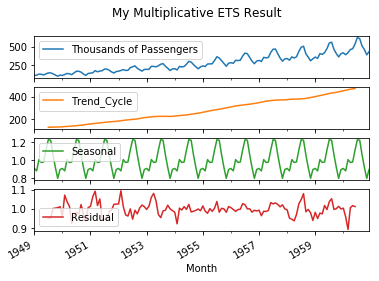

In [10]:
build_in_ETS_fig(build_in_result_multi, title='Bulid-in ETS with Multiplicative Model')

ETS_result_multiplicative = ETS_decompose(airline, 12, model = 'multiplicative')
ETS_result_multiplicative.plot(subplots=True, title='My Multiplicative ETS Result')


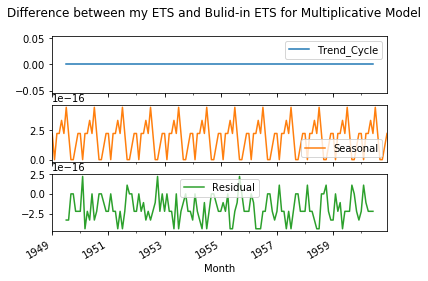

In [11]:
# plot figure to check if my result is actually same as Python seasonal_decompose
aa = build_in_result_multi.trend - ETS_result_multiplicative['Trend_Cycle']
bb = build_in_result_multi.seasonal - ETS_result_multiplicative['Seasonal']
cc = build_in_result_multi.resid - ETS_result_multiplicative['Residual']

difference_multi =  pd.concat([aa,bb,cc], axis=1,  join_axes=[a.index])
difference_multi.columns=['Trend_Cycle', 'Seasonal', 'Residual']
difference_multi_plot = difference_multi.plot(subplots=True, title='Difference between my ETS and Bulid-in ETS for Multiplicative Model')